Автор -- Прокудин Максим.

tg для связи -- @evdgenij

Ник на kaggle -- JKOOUP

Соревнование -- https://www.kaggle.com/c/advanced-dls-fall-2020/overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка и очистка данных

Загрузим данные и проверим их на наличие Nan'ов.

In [2]:
data = pd.read_csv('./train.csv')
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5136,6,85.95,514.6,Female,0,No,No,Yes,No,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Mailed check,0
3812,43,106.00,4532.3,Female,0,No,Yes,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,One year,Yes,Credit card (automatic),0
3520,38,70.15,2497.35,Male,1,No,No,Yes,No,DSL,No,Yes,Yes,Yes,Yes,No,One year,Yes,Credit card (automatic),1
2192,23,95.30,2192.9,Male,0,No,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,No,Mailed check,0
2721,56,104.75,5510.65,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),1


Для начала удалим дупликаты.

In [3]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   object 
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlin

Заметим, что численный признак TotalSpent почему-то имеет тип object, хотя должен быть float64. При попыке исправить это, я обнаружил, что некоторые значения TotalSpent равны пробелам.

In [4]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Заменим все пробелы на 0. Далее восстановим их.

In [5]:
print((data['TotalSpent'] == ' ').sum())
data['TotalSpent'] = data['TotalSpent'].apply(lambda x : '0' if x == ' ' else x)
data['TotalSpent'] = data['TotalSpent'].astype("float64")
data.info()

9
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnl

Так же логично предположить, что общая сумма, уплаченная клиентом находиться в отрезке:
$$[data['MonthlySpending'] * (data['ClientPeriod'] - 1); data['MonthlySpending'] * (data['ClientPeriod'] + 1)]$$

In [6]:
l_bound = np.array(data['MonthlySpending'] * (data['ClientPeriod'] - 1), dtype='float64')
r_bound = np.array(data['MonthlySpending'] * (data['ClientPeriod'] + 1), dtype='float64')
mid = np.array(data['TotalSpent'], dtype='float64')

In [7]:
mid = np.array([np.max([l_bound[i], mid[i]]) for i in range(mid.shape[0])])
mid = np.array([np.min([r_bound[i], mid[i]]) for i in range(mid.shape[0])])
data['TotalSpent'] = mid

# Анализ данных

Построим гистограммы численных признаков.

[]

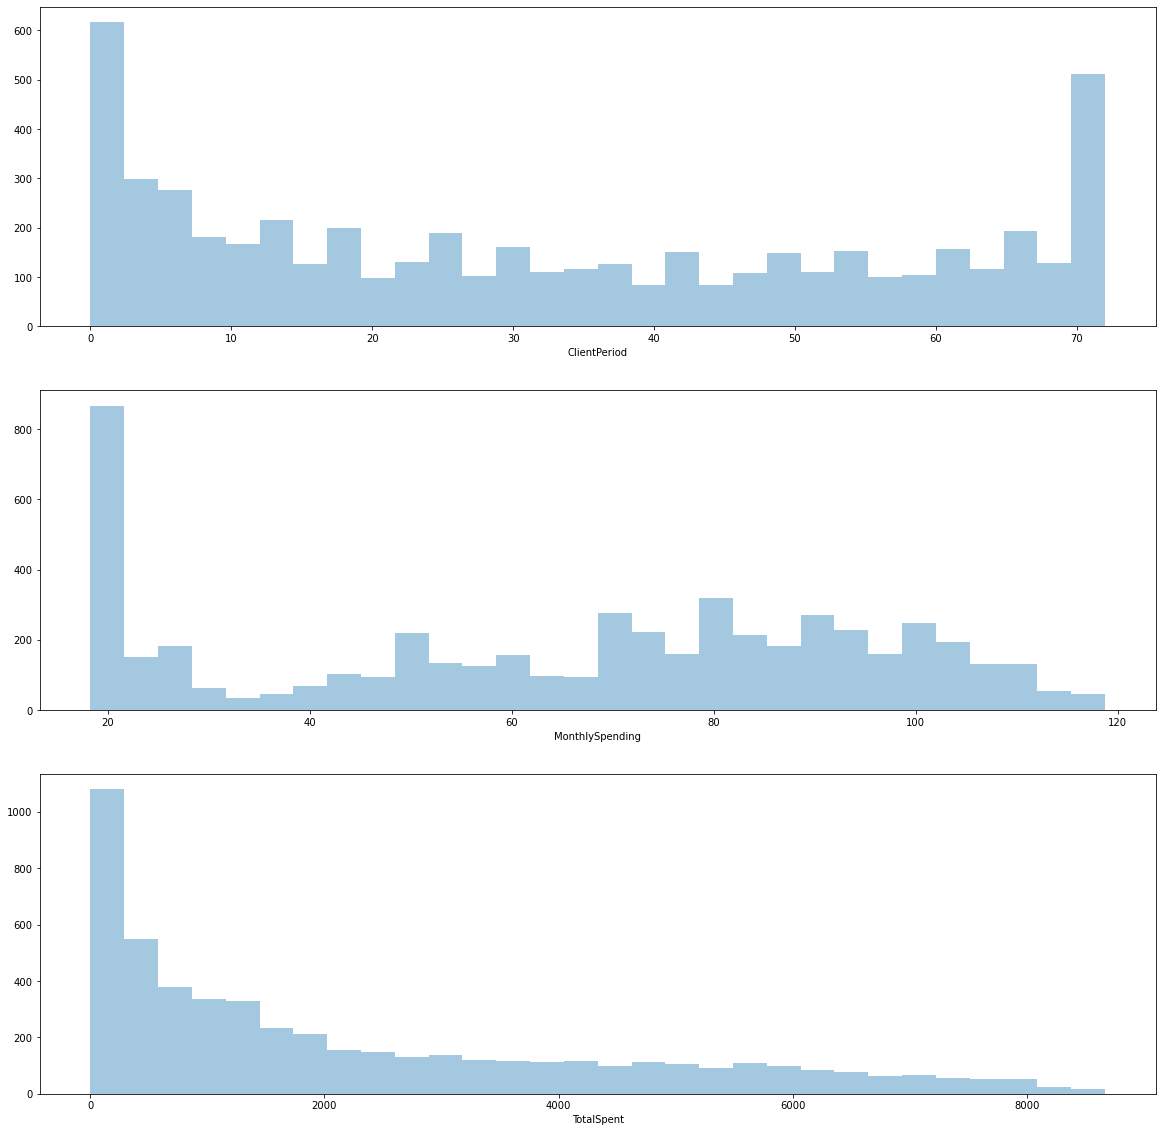

In [8]:
f, axes = plt.subplots(len(num_cols), 1, figsize=(20, 20))

for idx, col in enumerate(num_cols):
    sns.distplot(data[col], bins=30, kde=False, ax=axes[idx])

plt.plot()

[]

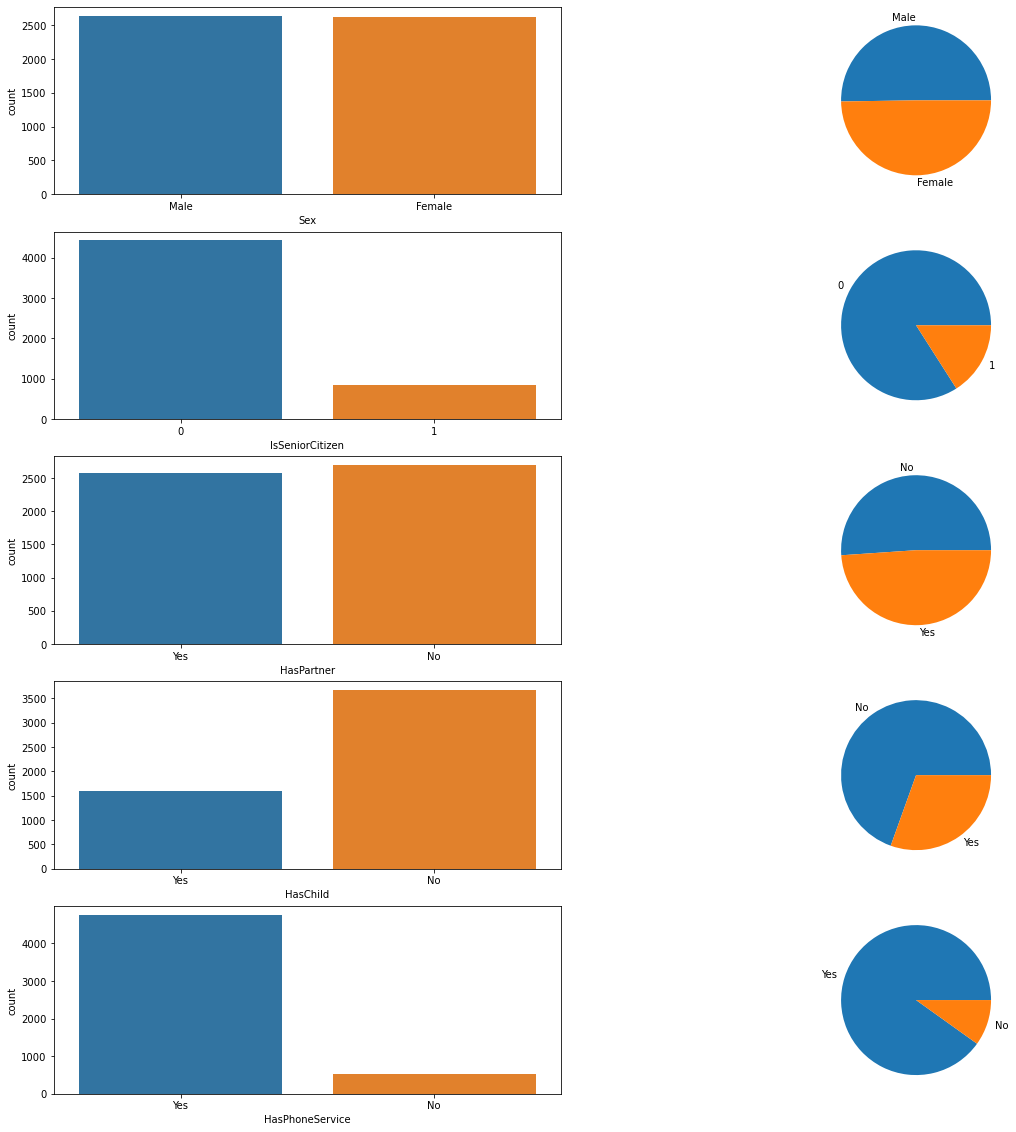

In [9]:
f, axes = plt.subplots(len(cat_cols[:5]), 2, figsize=(20, 20))

for idx, col in enumerate(cat_cols[:5]):
    columns = data[col].value_counts().index
    rows = data[col].value_counts().values
    
    sns.countplot(data[col], ax=axes[idx, 0])
    axes[idx, 1].pie(rows, labels=columns)

plt.plot()

[]

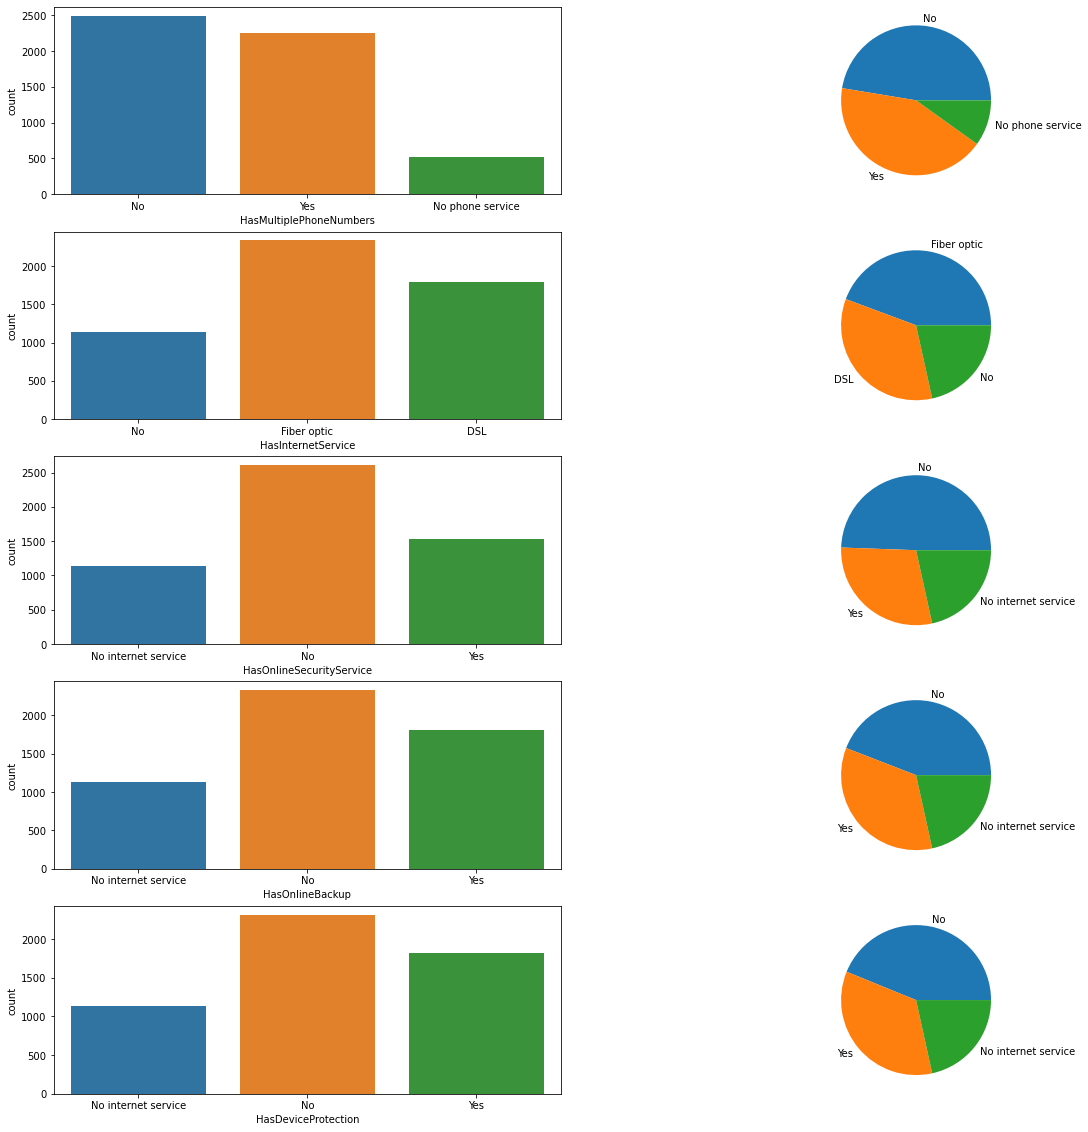

In [10]:
f, axes = plt.subplots(len(cat_cols[5:10]), 2, figsize=(20, 20))

for idx, col in enumerate(cat_cols[5:10]):
    columns = data[col].value_counts().index
    rows = data[col].value_counts().values
    
    sns.countplot(data[col], ax=axes[idx, 0])
    axes[idx, 1].pie(rows, labels=columns)

plt.plot()

[]

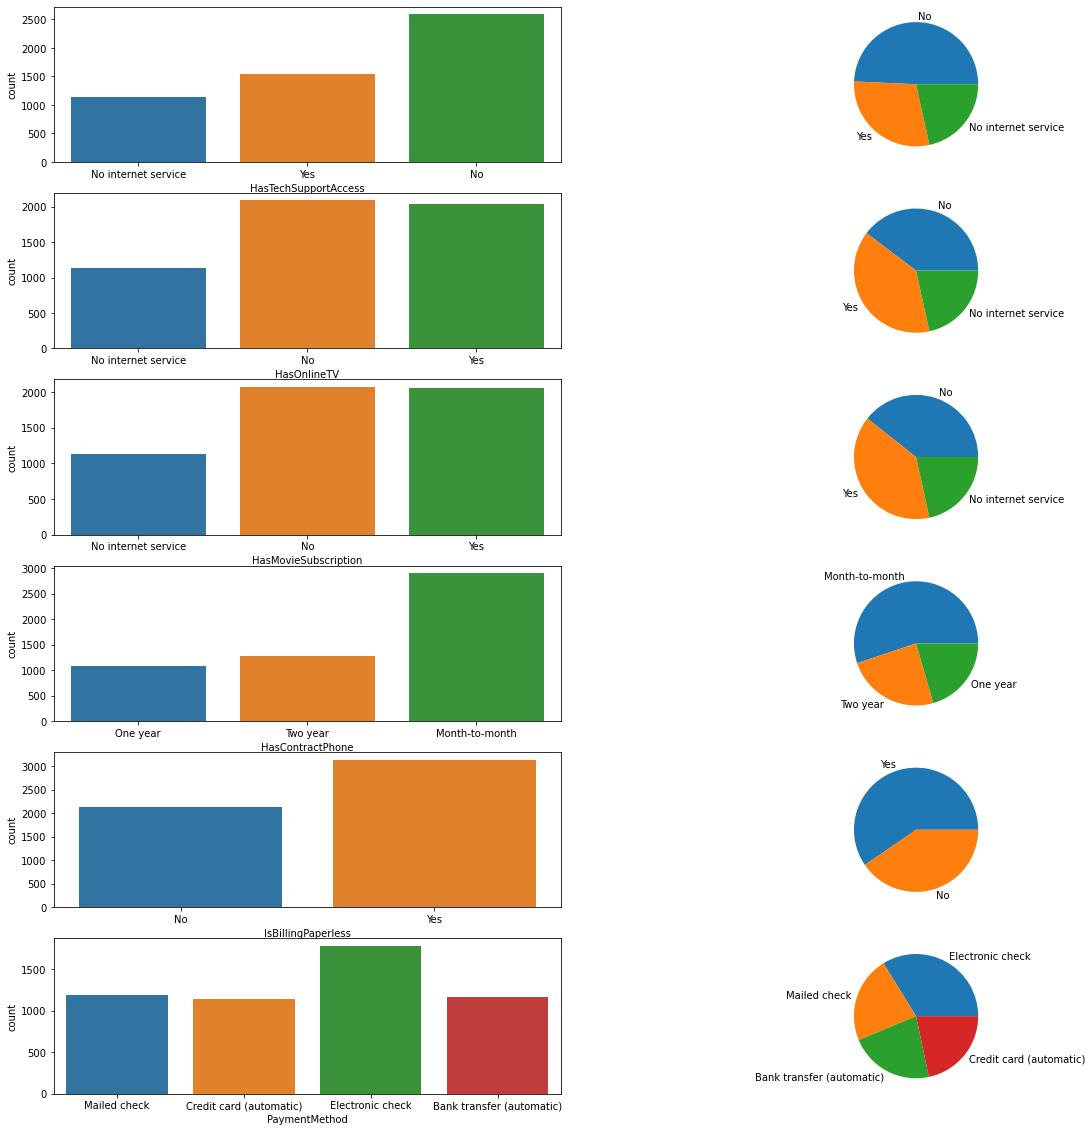

In [11]:
f, axes = plt.subplots(len(cat_cols[10:]), 2, figsize=(20, 20))

for idx, col in enumerate(cat_cols[10:]):
    columns = data[col].value_counts().index
    rows = data[col].value_counts().values
    
    sns.countplot(data[col], ax=axes[idx, 0])
    axes[idx, 1].pie(rows, labels=columns)

plt.plot()

Посмотрим на распределение целевой переменной.

[]

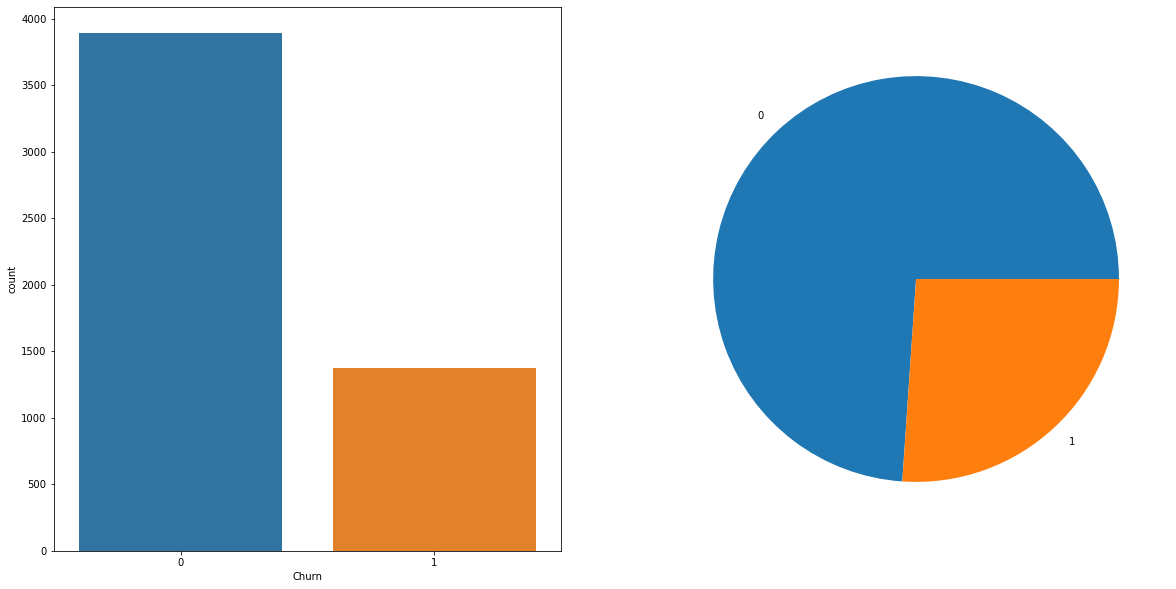

In [12]:
f, axes = plt.subplots(1, 2, figsize=(20, 10))

column = data[target_col].value_counts().index
row = data[target_col].value_counts().values

sns.countplot(x=data[target_col], ax=axes[0])
axes[1].pie(row, labels=column)
plt.plot()

Классы не сбалансированны, так как класса 1 примерно в 3 раза меньше, чем класса 2. Тем не менее, это не так много. 

Так же интересно посмотреть на зависимости между целевой переменной и категориальными признаками.

[]

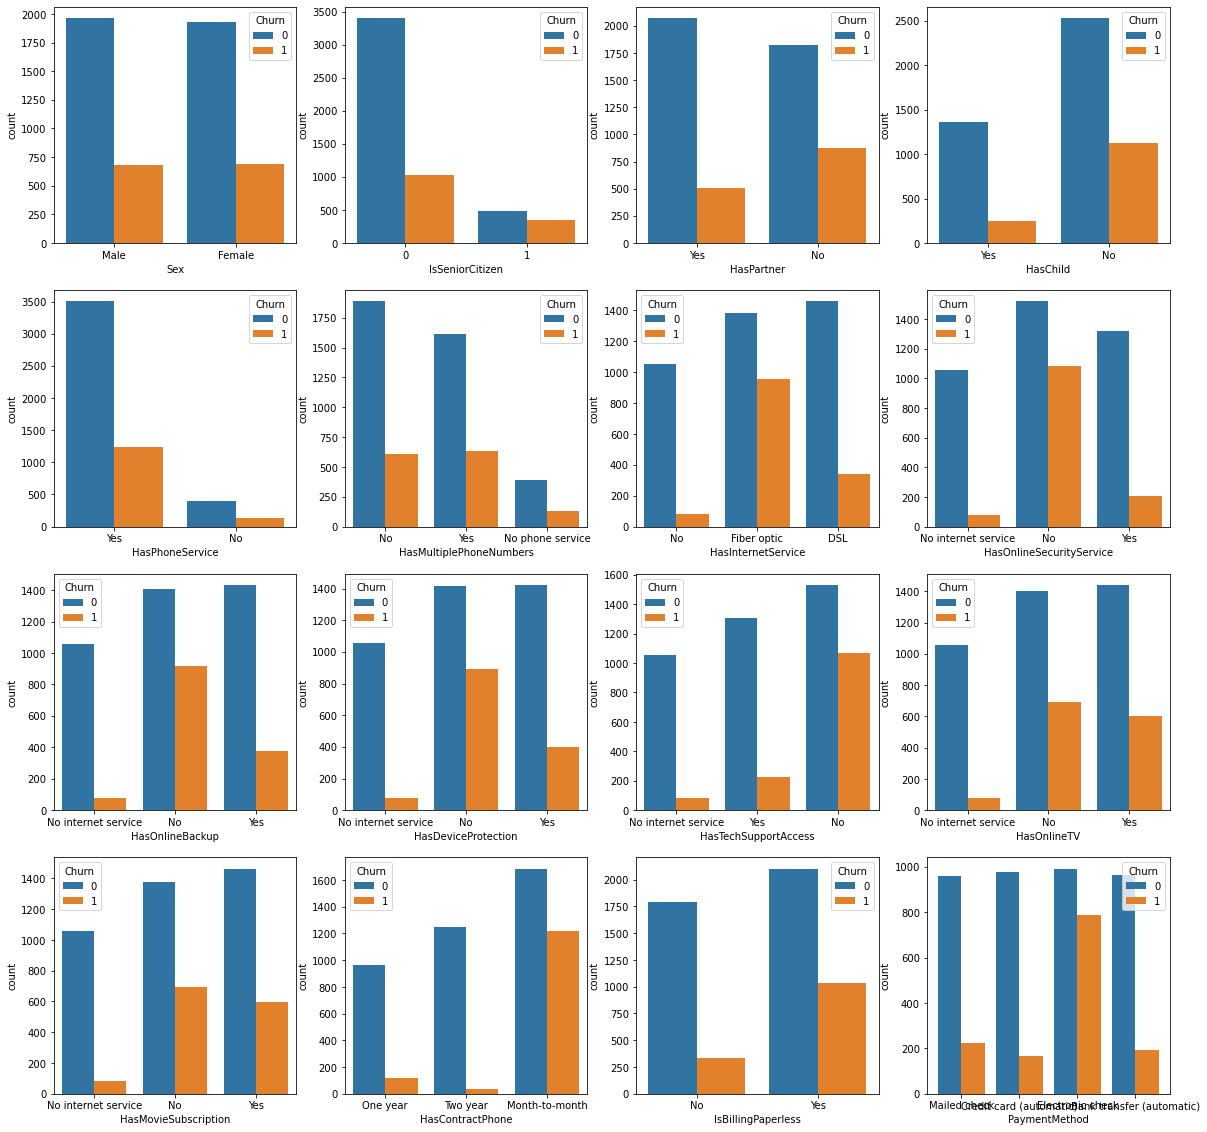

In [13]:
f, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, col in enumerate(cat_cols):
    sns.countplot(x=data[col], hue="Churn", data=data, ax=axes[i // 4, i % 4])
    
plt.plot()

Данные графики не помогли мне улучшить качество модели, тем не менее из них можно понять какаие именно категории людей перестают пользоваться услугами кампании. Например, люди, которые пользуются услугами интернета с Fiber optic, уходят намного чаще, чем люди c DLS. Возможно у Fiber optic есть проблемы.

# Применение линейных моделей

Попробуем получить некоторые предсказания с помощью логистической регрессии. Для начала подготовим данные.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Численные признаки отнормируем с помощью StandardScaler'а.

In [15]:
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

Бинарные категориальные признаки закодируем с помощью LabelEncodera'a.

In [16]:
bin_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'IsBillingPaperless'
]

cat_cols_wb = [
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'PaymentMethod'
]

In [17]:
lenc = np.array([LabelEncoder() for i in range(len(bin_cols))])
for i, col in enumerate(bin_cols):
    data[col] = lenc[i].fit_transform(data[col])

Остальные категориальные признаки закодируем с помощью OneHotEncoder'a.

In [18]:
ohe = OneHotEncoder(sparse=False)

new_cols = [col + '_' + str(j) for col in cat_cols_wb for j in range(data[col].unique().shape[0])]

ohe_data = pd.DataFrame(ohe.fit_transform(data[cat_cols_wb]), columns = new_cols, index=data[num_cols].index)

In [19]:
prep_data = pd.concat([data[num_cols], data[bin_cols], ohe_data, data[target_col]], axis=1)
prep_data[bin_cols + new_cols] = prep_data[bin_cols + new_cols].astype('int64')
prep_data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,HasMultiplePhoneNumbers_0,...,HasMovieSubscription_1,HasMovieSubscription_2,HasContractPhone_0,HasContractPhone_1,HasContractPhone_2,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Churn
4645,-0.345758,0.312279,-0.255967,1,0,1,0,1,0,1,...,0,1,0,1,0,1,0,0,0,0
973,0.510437,-0.080454,0.221619,0,0,0,0,1,1,1,...,0,0,0,1,0,0,1,0,0,0
167,1.570489,-1.500591,-0.403137,1,0,1,1,1,0,1,...,1,0,0,0,1,0,1,0,0,0
1741,0.428895,1.137515,0.844634,0,0,1,1,1,1,0,...,0,1,1,0,0,1,0,0,0,0
2446,1.122005,-0.118568,0.592651,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0


In [20]:
prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5268 entries, 0 to 5281
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ClientPeriod                5268 non-null   float64
 1   MonthlySpending             5268 non-null   float64
 2   TotalSpent                  5268 non-null   float64
 3   Sex                         5268 non-null   int64  
 4   IsSeniorCitizen             5268 non-null   int64  
 5   HasPartner                  5268 non-null   int64  
 6   HasChild                    5268 non-null   int64  
 7   HasPhoneService             5268 non-null   int64  
 8   IsBillingPaperless          5268 non-null   int64  
 9   HasMultiplePhoneNumbers_0   5268 non-null   int64  
 10  HasMultiplePhoneNumbers_1   5268 non-null   int64  
 11  HasMultiplePhoneNumbers_2   5268 non-null   int64  
 12  HasInternetService_0        5268 non-null   int64  
 13  HasInternetService_1        5268 

In [21]:
y = prep_data[target_col]
X = prep_data.drop(target_col, axis=1)

Теперь обучим линейную регрессию, сразу использовав GridSearchCV для поиска оптимальных параметров.

In [22]:
log_gs = GridSearchCV(LogisticRegression(fit_intercept=False), 
                      param_grid = {
                          "C": [10**i for i in range(-5, 6)],
                          "max_iter": np.linspace(10, 2000, 30, dtype="int64")
                      }, 
                      n_jobs=-1, cv=5, scoring='roc_auc', verbose=10)
log_gs.fit(X, y)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1907s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1069s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1805s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  

GridSearchCV(cv=5, estimator=LogisticRegression(fit_intercept=False), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000],
                         'max_iter': array([  10,   78,  147,  215,  284,  353,  421,  490,  558,  627,  696,
        764,  833,  902,  970, 1039, 1107, 1176, 1245, 1313, 1382, 1451,
       1519, 1588, 1656, 1725, 1794, 1862, 1931, 2000])},
             scoring='roc_auc', verbose=10)

In [23]:
log_gs.best_estimator_

LogisticRegression(C=10, fit_intercept=False, max_iter=78)

In [24]:
log_gs.best_score_

0.8445261917518028

Таким образом лучшее качество было получено с параметрами:
1. C = 10
2. max_iter = 78

# Применение CatBoost 

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

Загрузим и очистим данные.

In [26]:
X = pd.read_csv('./train.csv')
X = X.drop_duplicates()
X['TotalSpent'] = mid

In [27]:
y = X['Churn']
X = X.drop(target_col, axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [29]:
model = CatBoostClassifier(cat_features=cat_cols, verbose=0, eval_metric='AUC')

Посмотрим на скор без тюнинга параметров.

In [30]:
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]

In [31]:
roc_auc_score(y_test, preds)

0.8427245289921347

Далее подберем оптимальныые гиперпараметры (эти блоки можно не запускать, так как работают они долго, а найденные параметры я выписал ниже).

In [32]:
scores = []
for i in tqdm([100, 200, 300, 500, 1000, 2000, 5000]):
    model_i = CatBoostClassifier(n_estimators=i, cat_features=cat_cols, verbose=0, eval_metric='AUC')
    
    model_i.fit(X_train, y_train)
    score = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])
    scores.append(score)

100%|██████████| 7/7 [01:12<00:00, 10.31s/it]


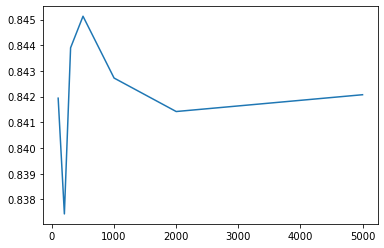

In [33]:
plt.plot([100, 200, 300, 500, 1000, 2000, 5000], scores)

In [34]:
scores = []
for i in tqdm([1, 2, 3, 4, 5]):
    model_i = CatBoostClassifier(n_estimators=1000, 
                                 depth=i,
                                 cat_features=cat_cols, verbose=0, eval_metric='AUC')
    
    model_i.fit(X_train, y_train)
    score = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])
    scores.append(score)

100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


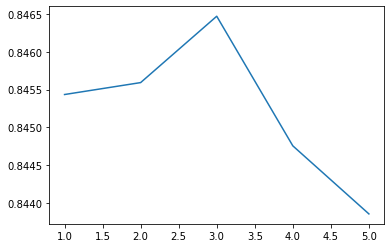

In [35]:
plt.plot([1, 2, 3, 4, 5], scores)

In [36]:
scores = []
for i in tqdm(np.linspace(0.001, 0.5, 20)):
    model_i = CatBoostClassifier(n_estimators=1000, 
                                 depth=3,
                                 learning_rate=i,
                                 cat_features=cat_cols, verbose=0, eval_metric='AUC')
    
    model_i.fit(X_train, y_train)
    score = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])
    scores.append(score)

100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


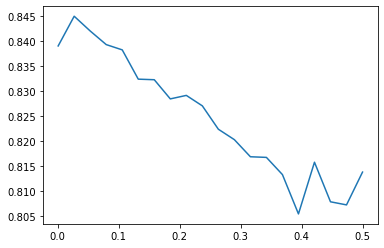

In [37]:
plt.plot(np.linspace(0.001, 0.5, 20), scores)

In [38]:
scores = []
for i in tqdm(np.linspace(1, 10, 20)):
    model_i = CatBoostClassifier(n_estimators=1000, 
                                 depth=3,
                                 learning_rate=0.03,
                                 l2_leaf_reg=i,
                                 cat_features=cat_cols, verbose=0, eval_metric='AUC')
    
    model_i.fit(X_train, y_train)
    score = roc_auc_score(y_test, model_i.predict_proba(X_test)[:, 1])
    scores.append(score)

100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


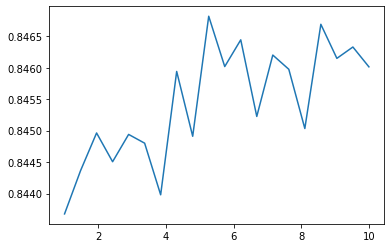

In [39]:
plt.plot(np.linspace(1, 10, 20), scores)

Лучшие, найденные мной параметры не совпадают с полученными выше, так как я очень много эксперементировал с перебором и сейчас уже не смогу восстановить все те промежутки параметров, на которых я их перебирал. Я пробовал использовать GridSearchCV, но найденные с его помощью параметры давали результаты хуже. С помощью переборов аналогичных тем, что выше, я нашел:
1. n_estimators = 1225
2. depth = 3
3. learning_rate = 0.03
4. l2_leaf_reg = 6.526315789473684

Таким образом лучший скор я получил с помощью CatBoost'a:

In [40]:
cboost = CatBoostClassifier(n_estimators=1225,
                            depth=3,
                            learning_rate=0.03,
                            l2_leaf_reg=6.526315789473684,
                            cat_features=cat_cols, verbose=0, eval_metric='AUC')
cboost.fit(X_train, y_train)

# Предсказания

Для начала сделаем предскзания с помощью логистической регрессии. Скачаем и подготовим данные.

In [41]:
test_data = pd.read_csv('./test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

Тестовые данные так же содержат пропуски в TotalSpent, заполним их нулями.

In [42]:
print((test_data['TotalSpent'] == ' ').sum())
test_data['TotalSpent'] = test_data['TotalSpent'].apply(lambda x : '0' if x == ' ' else x)
test_data['TotalSpent'] = test_data['TotalSpent'].astype("float64")

2


Восстановим TotalSpent как в тестовых данных.

In [43]:
l_bound = np.array(test_data['MonthlySpending'] * (test_data['ClientPeriod'] - 1), dtype='float64')
r_bound = np.array(test_data['MonthlySpending'] * (test_data['ClientPeriod'] + 1), dtype='float64')
mid = np.array(test_data['TotalSpent'], dtype='float64')

In [44]:
mid = np.array([np.max([l_bound[i], mid[i]]) for i in range(mid.shape[0])])
mid = np.array([np.min([r_bound[i], mid[i]]) for i in range(mid.shape[0])])
test_data['TotalSpent'] = mid

Числовые признаки отнормируем StandardScaler'ом.

In [45]:
test_data[num_cols] = scaler.transform(test_data[num_cols])

Бинарные категориальные признаки транформируем с помощью LabelEncoder'ом.

In [46]:
for i, col in enumerate(bin_cols):
    test_data[col] = lenc[i].transform(test_data[col])

Небинарные категориальные признаки трансформуируем OneHotEncoder'ом.

In [48]:
ohe_test_data = pd.DataFrame(
    ohe.transform(test_data[cat_cols_wb]), 
    columns = new_cols,
    index=test_data[num_cols].index
)

Объединим все трансформированные данные.

In [49]:
prep_test_data = pd.concat([test_data[num_cols], test_data[bin_cols], ohe_test_data], axis=1)
prep_test_data[bin_cols + new_cols] = prep_test_data[bin_cols + new_cols].astype('int64')
prep_test_data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,HasMultiplePhoneNumbers_0,...,HasMovieSubscription_0,HasMovieSubscription_1,HasMovieSubscription_2,HasContractPhone_0,HasContractPhone_1,HasContractPhone_2,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
852,0.714293,-1.485677,-0.575011,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
532,-1.038869,-1.525447,-0.953404,1,0,0,0,1,1,1,...,0,1,0,1,0,0,0,0,0,1
919,-1.283496,0.847523,-0.971034,0,0,0,0,1,0,1,...,0,0,1,1,0,0,0,0,1,0
275,-1.283496,-0.476502,-0.988643,1,0,0,1,1,0,1,...,1,0,0,1,0,0,0,0,0,1
1232,-1.120411,1.031461,-0.811105,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0


In [50]:
log_model = LogisticRegression(C=10, fit_intercept=False, max_iter=78)

log_model.fit(prep_data.drop([target_col], axis=1), prep_data[target_col])

LogisticRegression(C=10, fit_intercept=False, max_iter=78)

In [51]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = log_model.predict_proba(prep_test_data)[:, 1]
submission.to_csv('./my_logreg_submission.csv', index=False)

Скор на каггле -- 0.84600

Теперь сделаем предсказания с помощью CatBoost'a.

In [52]:
test_data = pd.read_csv('./test.csv')
test_data['TotalSpent'] = test_data['TotalSpent'].apply(lambda x : '0' if x == ' ' else x)
test_data['TotalSpent'] = test_data['TotalSpent'].astype("float64")

In [53]:
l_bound = np.array(test_data['MonthlySpending'] * (test_data['ClientPeriod'] - 1), dtype='float64')
r_bound = np.array(test_data['MonthlySpending'] * (test_data['ClientPeriod'] + 1), dtype='float64')
mid = np.array(test_data['TotalSpent'], dtype='float64')

In [54]:
mid = np.array([np.max([l_bound[i], mid[i]]) for i in range(mid.shape[0])])
mid = np.array([np.min([r_bound[i], mid[i]]) for i in range(mid.shape[0])])
test_data['TotalSpent'] = mid

Здесь используем CatBoost, который я создал сразу после подбора гиперпараметров.

In [55]:
cboost.fit(X, y)

cboost_preds = cboost.predict_proba(test_data)[:, 1]

In [56]:
submission_cboost = pd.read_csv('./submission.csv')

submission_cboost['Churn'] = cboost_preds
submission_cboost.to_csv('./my_cboost_submission.csv', index=False)

Скор на каггле -- 0.85470